In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

sys.path.append("..")
from modules.utils import paper_style
from sklearn.metrics import r2_score

paper_style()

from helper_fn import *

sys.path.append("..")

# from modules.utils import paper_style

# loading GT stuff

# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = ""
relative_path = "../data"
path = os.path.join(current_dir, relative_path)
gt_path = os.path.join(path, "GT/")
gt_drug_path = os.path.join(path, "GT_drug/labels/")


gt_tracks = []
gt_drug_tracks = []
taus = []
taus_drugs = []
for i, fn in enumerate(os.listdir(gt_path)):
    track = np.load(os.path.join(gt_path, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks.append(track)
    taus.append(tau)

for i, fn in enumerate(os.listdir(gt_drug_path)):
    track = np.load(os.path.join(gt_drug_path, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_drug_tracks.append(track)
    taus_drugs.append(tau)


# tr_green = 0.035
# tr_phase_green = 0.15

tr_green = 0.10
tr_phase_green = 0.4

crossing_points_gt, idx_gt = find_crossing_points(taus, gt_tracks)
crossing_points_drugs, idx_drugs = find_crossing_points(
    taus_drugs,
    gt_drug_tracks,
    drug=True,
    tr_green=tr_green,
    tr_phase_green=tr_phase_green,
)

track_lengths = [track.shape[0] for track in gt_tracks]
track_lengths_drugs = [track.shape[0] for track in gt_drug_tracks]

Text(0.5, 1.0, 'Track lengths')

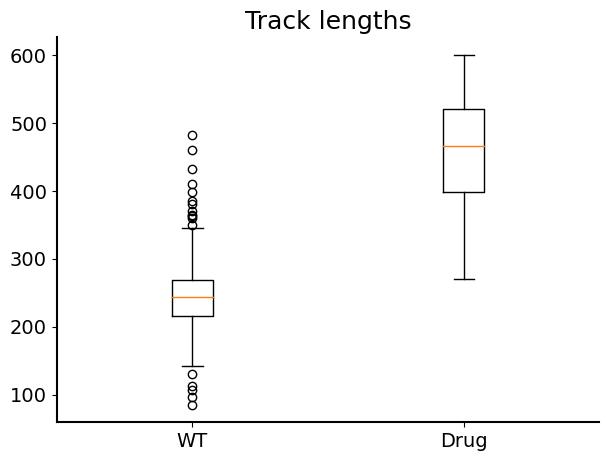

In [3]:
# box plot of track lengths
plt.figure()
plt.boxplot([track_lengths, track_lengths_drugs])
plt.xticks([1, 2], ["WT", "Drug"])
plt.title("Track lengths")

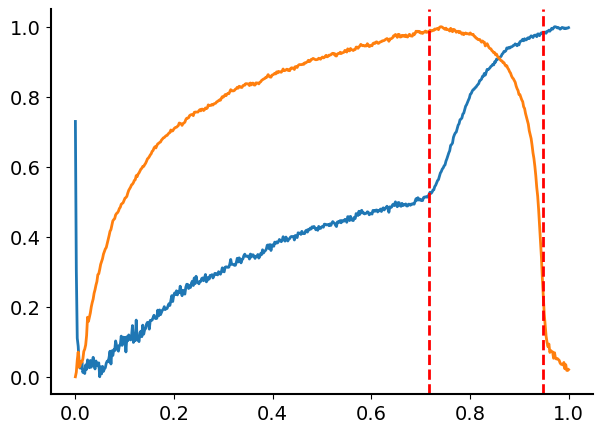

In [4]:
# random index from gt_drug_tracks
idx = np.random.randint(0, len(gt_drug_tracks))

# plot of the track
plt.figure()
plt.plot(taus_drugs[idx], gt_drug_tracks[idx])

# plot of the crossing points
plt.axvline(crossing_points_drugs[idx][0], color="red", linestyle="--")
plt.axvline(crossing_points_drugs[idx][1], color="red", linestyle="--")

In [5]:
idx_gt.mean(0)[0]

def mean_len_phases(gt):
    len_g1 = np.nanmean(gt, axis=0)[0] * 5
    len_s = (np.nanmean(gt, axis=0)[1] - np.nanmean(gt, axis=0)[0]) * 5

    return len_g1, len_s

mean_len_g1, mean_len_s = mean_len_phases(idx_gt)
mean_len_g1_drugs, mean_len_s_drugs = mean_len_phases(idx_drugs)

In [6]:
print(f"len G1: {mean_len_g1:.2f}, len S: {mean_len_s:.2f}")
print(f"len G1 drugs: {mean_len_g1_drugs:.2f}, len S drugs: {mean_len_s_drugs:.2f}")

len G1: 394.08, len S: 414.57
len G1 drugs: 1478.97, len S drugs: 590.48


([<matplotlib.axis.XTick at 0x167b43190>,
 [Text(1, 0, 'G1'),
  Text(2, 0, 'S'),
  Text(3, 0, 'G1 drugs'),
  Text(4, 0, 'S drugs')])

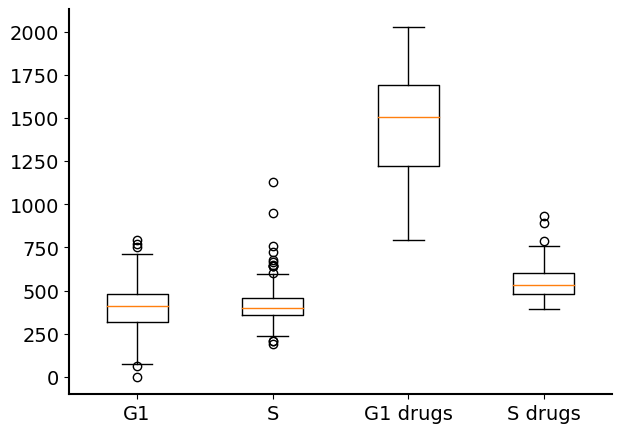

In [7]:
len_g1 = idx_gt[:, 0] * 5
len_s = (idx_gt[:, 1] - idx_gt[:, 0]) * 5

len_g1_drugs = idx_drugs[:, 0] * 5
len_s_drugs = (idx_drugs[:, 1] - idx_drugs[:, 0]) * 5
# remove nans 
len_s_drugs = len_s_drugs[~np.isnan(len_s_drugs)]

plt.figure()
plt.boxplot([len_g1, len_s, len_g1_drugs, len_s_drugs])
plt.xticks([1, 2, 3, 4], ["G1", "S", "G1 drugs", "S drugs"])